In [2]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt 

from utils.dataset import IOSMapDataset, IOSQueryDataset, IOSNeighborPairs, \
                        build_retrieval_loaders, collate_map, collate_query
                        

### data usage 

In [3]:
root = "/media/jbhayet/Data/datasets/crocodl-dataset/capture/HYDRO/sessions"  # contains ios_map/ and ios_query/
tfm = T.Compose([T.Resize((480, 640)), T.ToTensor()])  # or your own

# 1) Mapping / BA (poses + intrinsics)
map_ds = IOSMapDataset(root, transform=tfm, subsession="ios_2023-10-27_10.20.23_000")
map_loader = DataLoader(map_ds, batch_size=4, shuffle=False, collate_fn=collate_map)
map_batch = next(iter(map_loader))

imgs = map_batch["image"]      # (B,3,H,W)
K = map_batch["K"]             # (B,3,3)
Twc_list = map_batch["Twc"]    # list of 4x4 or None
split = map_batch["split"]
subsession = map_batch["subsession"]
timestamp = map_batch["timestamp"]
sensor_id = map_batch["sensor_id"]
path = map_batch["path"]

# 3) VO / relative-pose pairs within a subsession
pairs = IOSNeighborPairs(map_ds, stride=1)
pair_loader = DataLoader(pairs, batch_size=1, shuffle=False)

In [4]:
print(f"subsessions:\n{map_ds.idx.subsessions}")

subsessions:
['ios_2023-10-27_10.20.23_000', 'ios_2023-10-27_10.27.17_000', 'ios_2023-10-27_10.29.00_000', 'ios_2023-10-27_11.38.32_000', 'ios_2023-10-27_11.46.47_000', 'ios_2023-10-27_11.58.55_000', 'ios_2024-05-17_15.24.59_000']


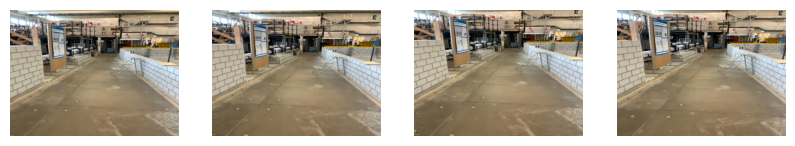

In [5]:
fig = plt.figure(figsize=(10, 10))
for i, img in enumerate(imgs):
    plt.subplot(1, 4, i + 1); 
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")


In [6]:
print(Twc_list)

[tensor([[ 2.2441e-01,  2.6200e-01, -9.3862e-01,  2.7926e+01],
        [ 9.7447e-01, -5.2880e-02,  2.1822e-01, -2.5139e+01],
        [ 7.5394e-03, -9.6362e-01, -2.6717e-01, -8.6350e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64), tensor([[ 2.2552e-01,  2.7399e-01, -9.3492e-01,  2.7914e+01],
        [ 9.7417e-01, -5.2010e-02,  2.1975e-01, -2.5143e+01],
        [ 1.1583e-02, -9.6033e-01, -2.7864e-01, -8.6368e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64), tensor([[ 2.3147e-01,  3.0339e-01, -9.2433e-01,  2.7818e+01],
        [ 9.7283e-01, -7.6355e-02,  2.1856e-01, -2.5156e+01],
        [-4.2703e-03, -9.4980e-01, -3.1282e-01, -8.6541e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64), tensor([[ 2.2738e-01,  2.9787e-01, -9.2713e-01,  2.7572e+01],
        [ 9.7377e-01, -6.0982e-02,  2.1922e-01, -2.5062e+01],
        [ 8.7623e-03, -9.5266e-01, -3.039

In [4]:
print(split); print(subsession); print(timestamp); print(sensor_id); print(path)

['map', 'map', 'map', 'map']
['ios_2023-10-27_10.20.23_000', 'ios_2023-10-27_10.20.23_000', 'ios_2023-10-27_10.20.23_000', 'ios_2023-10-27_10.20.23_000']
[594450497982, 594451097721, 594451697461, 594452297200]
['ios_2023-10-27_10.20.23_000/cam_phone_594450497982', 'ios_2023-10-27_10.20.23_000/cam_phone_594451097721', 'ios_2023-10-27_10.20.23_000/cam_phone_594451697461', 'ios_2023-10-27_10.20.23_000/cam_phone_594452297200']
['/media/jbhayet/Data/datasets/crocodl-dataset/capture/HYDRO/sessions/ios_map/raw_data/ios_2023-10-27_10.20.23_000/images/594450497982.jpg', '/media/jbhayet/Data/datasets/crocodl-dataset/capture/HYDRO/sessions/ios_map/raw_data/ios_2023-10-27_10.20.23_000/images/594451097721.jpg', '/media/jbhayet/Data/datasets/crocodl-dataset/capture/HYDRO/sessions/ios_map/raw_data/ios_2023-10-27_10.20.23_000/images/594451697461.jpg', '/media/jbhayet/Data/datasets/crocodl-dataset/capture/HYDRO/sessions/ios_map/raw_data/ios_2023-10-27_10.20.23_000/images/594452297200.jpg']


### DINOv3 

In [7]:
import torch
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
import numpy as np 

from utils.dataset import IOSMapDataset, collate_map

In [8]:
# load model 
REPO_DIR = "submodules/dinov3"
weights = "/media/jbhayet/Data/datasets/croco-experiments/checkpoints/dinov3_vitb16.pth"

# DINOv3 ViT models pretrained on web images
dinov3_vitb16 = torch.hub.load(
    REPO_DIR, 'dinov3_vitb16', source='local', weights=weights
).to("cuda:0")
print(f"Model num features: {dinov3_vitb16.num_features}")

Model num features: 768


In [9]:
from torchinfo import summary

summary(dinov3_vitb16, input_size=(1, 3, 224, 224), col_names=("input_size","output_size","num_params","kernel_size"))

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape
DinoVisionTransformer                         [1, 3, 224, 224]          [1, 768]                  4,608                     --
├─PatchEmbed: 1-1                             [1, 3, 224, 224]          [1, 14, 14, 768]          --                        --
│    └─Conv2d: 2-1                            [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   [16, 16]
│    └─Identity: 2-2                          [1, 196, 768]             [1, 196, 768]             --                        --
├─RopePositionEmbedding: 1-2                  --                        [196, 64]                 --                        --
├─ModuleList: 1-25                            --                        --                        (recursive)               --
│    └─SelfAttentionBlock: 2-3                [1, 201, 768]             [1, 201, 768]          

In [10]:
# preprocessing function 
def make_transform(resize_size: int = 224):
    to_tensor = transforms.ToTensor()
    resize = transforms.Resize((resize_size, resize_size), antialias=True)
    normalize = transforms.Normalize(
        mean=(0.430, 0.411, 0.296),
        std=(0.213, 0.156, 0.143),
    )
    return transforms.Compose([to_tensor, resize, normalize])

tfm = make_transform()

In [11]:
# load dataset 
root = "/media/jbhayet/Data/datasets/crocodl-dataset/capture/HYDRO/sessions"  # contains ios_map/ and ios_query/
map_ds = IOSMapDataset(root, transform=tfm)
map_loader = DataLoader(map_ds, batch_size=4, shuffle=False, collate_fn=collate_map)
map_batch = next(iter(map_loader))

imgs = map_batch["image"].to("cuda")      # (B,3,H,W)

In [12]:
with torch.no_grad():
    img_feats = dinov3_vitb16.get_intermediate_layers(imgs, reshape=True)[0]

In [13]:
with torch.no_grad():
    imgs_embed = dinov3_vitb16(imgs)

In [14]:
img_feats.shape, imgs_embed.shape

(torch.Size([4, 768, 14, 14]), torch.Size([4, 768]))

In [15]:
# upsample feats to image size 
size = (imgs[0].shape[-2], imgs[0].shape[-1])
feat_up = torch.nn.functional.interpolate(
    input=img_feats, size=size, mode="bilinear", align_corners=False 
)

In [16]:
feat_up.shape

torch.Size([4, 768, 224, 224])

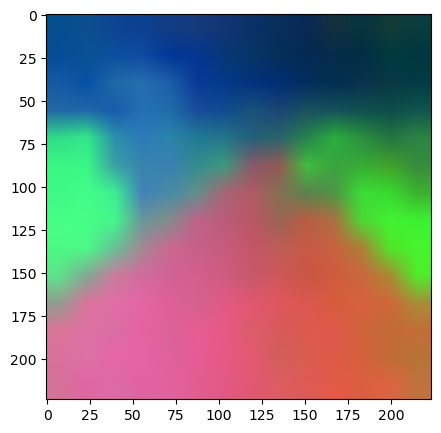

In [17]:
# plot 
_, _, h, w = feat_up.shape
feat_pca = feat_up[0].permute((1,2,0))
projected_featmap = feat_pca.reshape(-1, feat_pca.shape[-1]).cpu()

pca = PCA(n_components=3)
pca.fit(projected_featmap)
pca_features = pca.transform(projected_featmap)
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
pca_features = pca_features * 255
pca_features = pca_features.reshape(h, w, 3).astype(np.uint8)

fig = plt.figure(figsize=(5, 5))
plt.imshow(pca_features); plt.show()